In [1]:
import matplotlib.pyplot as plt
plt.style.use("science")
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 250
import pandas as pd
import numpy as np
from glob import glob
mpl.rcParams.update({'font.size': 8})

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%b')
cname = "viridis"

In [2]:
def read_summary(file):
    df = pd.read_csv(file)
    df["time_stamp"] = pd.to_datetime(df["time_stamp"])
    df = df.groupby("time_stamp").sum()
    df = df.rolling("7D").mean()
    return df

In [3]:
files = np.sort(glob("../data/delta_infectivity/summary*.csv"))
summaries = [read_summary(f) for f in files]

In [4]:
delta_infs = np.linspace(1.5, 2.8, 14)

In [5]:
data_inf = pd.read_csv("../data/real_data/new_cases.csv")
data_inf.set_index("date", inplace=True)
data_inf.index = pd.to_datetime(data_inf.index)
data_inf.sort_index(inplace=True)
data_inf["newCasesBySpecimenDate"] = data_inf["newCasesBySpecimenDate"].rolling(window="7D").mean()

In [6]:
summaries[0]

,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,
2021-07-10,600061.250000,82312.000000,51.250000,264.000000,8.750000,8.000000,2.000000,4.000000
2021-07-11,620766.000000,61433.500000,62.625000,164.500000,10.375000,9.000000,2.000000,3.500000
2021-07-12,643583.066667,59665.000000,69.483333,130.333333,11.650000,9.333333,2.666667,4.000000
2021-07-13,667887.900000,58431.000000,76.912500,116.750000,12.287500,8.750000,4.250000,6.750000
2021-07-14,692001.080000,57278.000000,85.330000,112.200000,13.190000,9.400000,5.000000,8.200000
...,...,...,...,...,...,...,...,...
2022-02-05,8466.540476,145.000000,11.207143,1.428571,8.428571,0.285714,0.714286,0.714286
2022-02-06,7932.492857,143.142857,10.707143,1.285714,8.285714,0.285714,0.714286,0.714286
2022-02-07,7431.121429,131.714286,9.992857,1.142857,8.142857,0.285714,0.714286,0.714286


In [7]:
def plot_infections(ax, colorbar=True, legend=True):
    myFmt = mdates.DateFormatter('%b')
    colors = plt.get_cmap(cname)(np.linspace(0, 1, len(files)))
    for i, summ in enumerate(summaries):
        delta_inf = delta_infs[i]
        if delta_inf == 2.0:
            ax.plot(summ.index, summ["daily_infected"], color = "black", label = "BASELINE (2.0)", zorder=np.inf, linewidth=2)
            continue
        ax.plot(summ.index, summ["daily_infected"], color = colors[i])
    ax.plot(data_inf.index, data_inf["newCasesBySpecimenDate"], color = "tab:red", linestyle="--", label = "Data", linewidth=2)
    if colorbar:
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cname), norm=plt.Normalize(vmin=1.5, vmax=2.8))
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Delta infectivity / Wild-type infectivity", rotation=-90, labelpad=15)
    if legend:
        ax.legend()
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlim(pd.to_datetime("2021-07-10"), pd.to_datetime("2021-12-15"))
    ax.set_title("Daily infections")

In [8]:
# Taken from ONS infection survey

data_weekly = {("2021-07-09", "2021-07-15") : (1.26, 1.36, 1.46),
        ("2021-07-16", "2021-07-22") : (1.46, 1.57, 1.68),
        ("2021-07-23", "2021-07-29") : (1.23, 1.32, 1.42),
        ("2021-07-29", "2021-08-04") : (1.25, 1.33, 1.43),
        ("2021-08-06", "2021-08-12") : (1.19, 1.28, 1.37),
        ("2021-08-12", "2021-08-18") : (1.30, 1.39, 1.48),
       }

labels = [pd.to_datetime(dates[0]).date() for dates in data_weekly.keys()]
values_per_alpha = []
for df in summaries:
    asd = []
    for dates, values in data_weekly.items():
        toplot = df.loc[dates[0]:dates[1], "daily_infected"].sum() / 53000000 * 100
        asd.append(toplot)
    values_per_alpha.append(asd)

In [9]:
def plot_infections_weekly(ax, colorbar=True, legend=True):
    cmap = plt.get_cmap(cname)(np.linspace(0, 1, len(summaries)))

    for i in range(0,len(values_per_alpha)):
        label = np.linspace(1.5, 2.8, 14)[i]
        if label == 2.0:
            ax.plot(labels, values_per_alpha[i], "o-", color = "black",  markersize=2, label = "Baseline (2.0)", zorder=np.inf, linewidth=2)
            continue
        ax.plot(labels, values_per_alpha[i], "o-", color = cmap[i],  markersize=2)


    lowv = [vv[1] - vv[0] for vv in data_weekly.values()]
    midv = [vv[1] for vv in data_weekly.values()]
    highv = [vv[2] - vv[1] for vv in data_weekly.values()]

    ax.errorbar(labels, midv, yerr=(lowv, highv), fmt="o", color = "tab:red", capsize=3, markersize=2, label = "Data")
    if colorbar:
        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cname), norm=plt.Normalize(vmin=1.5, vmax=2.8))
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label("Delta / Wild-type infectivity", rotation=-90, labelpad=15)

    xlabels = ["2021-07-10", "2021-07-25", "2021-08-10"]
    ax.set_xticks(xlabels)
    ax.set_xticklabels(xlabels)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

    ax.set_title("\% people infected per week")
    if legend:
        ax.legend()


In [10]:
data_deaths = pd.read_csv("../data/real_data/deaths.csv")
data_deaths.set_index("date", inplace=True)
data_deaths.index = pd.to_datetime(data_deaths.index)
data_deaths.sort_index(inplace=True)
data_deaths

,areaType,areaName,areaCode,newDeaths28DaysByDeathDate,cumDeaths28DaysByDeathDate
date,,,,,
2020-03-02,nation,England,E92000001,1,1
2020-03-03,nation,England,E92000001,2,3
2020-03-04,nation,England,E92000001,0,3
2020-03-05,nation,England,E92000001,3,6
2020-03-06,nation,England,E92000001,0,6
...,...,...,...,...,...
2021-08-22,nation,England,E92000001,86,115883
2021-08-23,nation,England,E92000001,88,115971
2021-08-24,nation,England,E92000001,86,116057


In [11]:
def plot_deaths(ax, colorbar=True, legend=True):
    cmap = plt.get_cmap(cname)(np.linspace(0, 1, len(summaries)))

    for i, df in enumerate(summaries):
        label = np.linspace(1.5, 2.8, 14)[i]
        if label == 2.0:
            ax.plot(df.index, df["daily_deaths"].rolling(window="10D").mean(), color = "black",  markersize=2, label = "Baseline (2.0)", zorder=np.inf, linewidth=2)
            continue
        ax.plot(df.index, df["daily_deaths"].rolling(window="10D").mean(), color=cmap[i])


    data_toplot = data_deaths.loc["2021-07-10":].rolling(window="10D").mean()
    ax.plot(data_toplot.index, data_toplot["newDeaths28DaysByDeathDate"], label = "Data", color = "tab:red", linestyle="--", linewidth=2)
    if legend:
        ax.legend()
    ax.set_title("Daily deaths")
    ax.set_xlim(pd.to_datetime("2021-07-10"), pd.to_datetime("2021-12-15"))
    ax.xaxis.set_major_formatter(myFmt)
    if colorbar:

        sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cname), norm=plt.Normalize(vmin=1.5, vmax=2.8))
        cbar = plt.colorbar(sm,ax=ax)
        cbar.set_label("Delta / Wild-type infectivity", rotation=-90, labelpad=15)

# 3 plots at once

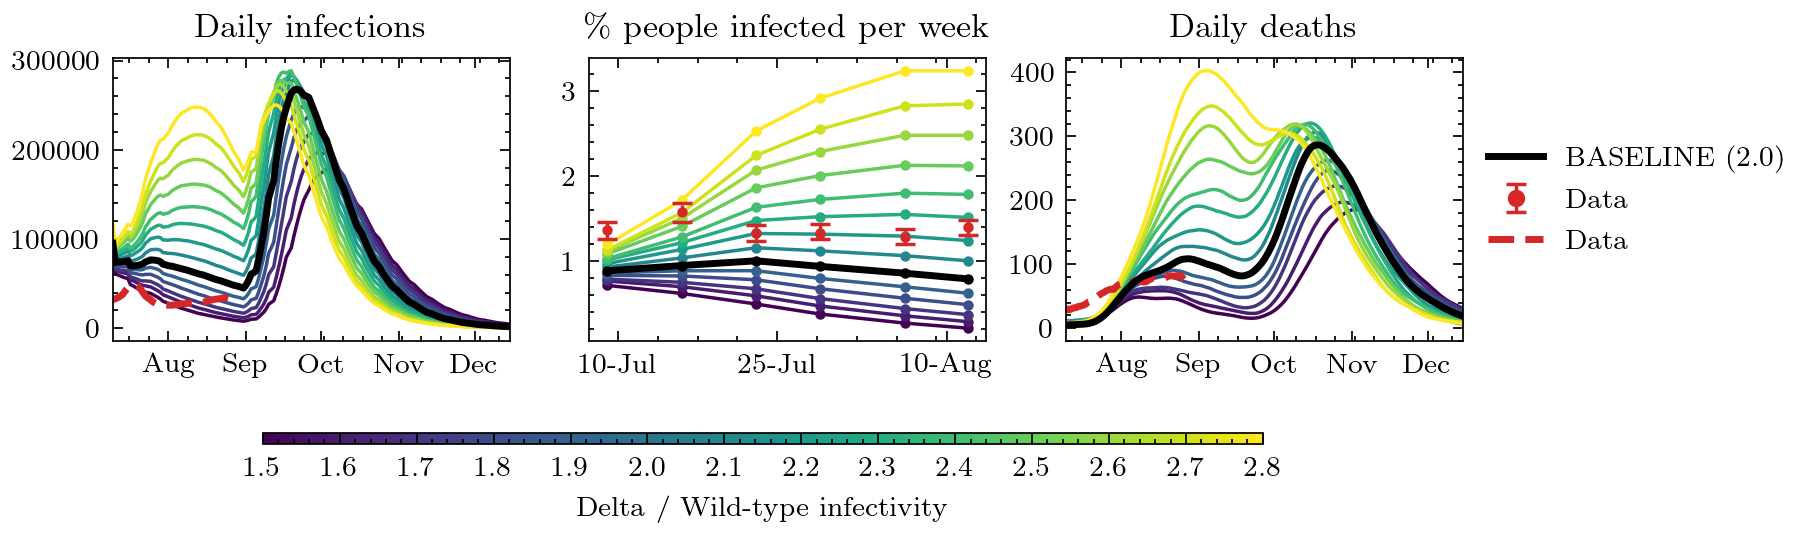

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(8,1.5))

cname = "viridis"

plot_infections(ax[0], colorbar=False, legend=False)
plot_infections_weekly(ax[1], colorbar=False, legend=False)
plot_deaths(ax[2], colorbar=False, legend=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.2, -0.15, 0.5, 0.03])
sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(cname), norm=plt.Normalize(vmin=1.5, vmax=2.8))
cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal", ticks=np.linspace(1.5, 2.8, 14))
cbar_ax.xaxis.set_label_position('bottom')
cbar_ax.xaxis.set_ticks_position('bottom')

cbar.set_label("Delta / Wild-type infectivity")

c1, = ax[2].plot([], [], color = "black", label = "BASELINE (2.0)", linewidth=2)
c2 = ax[2].errorbar([2], [2], yerr=([2], [2]), fmt="o", color = "tab:red", label = "Data", capsize=3, markersize=4)
c3, = ax[2].plot([], [], color = "tab:red", linestyle="--", label = "Data", linewidth=2)
ax[2].legend([c1,c2,c3], ["BASELINE (2.0)", "Data", "Data"], loc="center left", bbox_to_anchor=(1,0.5))


fig.subplots_adjust(wspace=0.2)
fig.savefig("../figures/FigS1_delta_infectivity.pdf")